# <center>Big Data &ndash; Exercises</center>
## <center>Fall 2021 &ndash; Week 7 &ndash; ETH Zurich</center>
## <center>MapReduce</center>


Reading: 
- White, T. (2015). Hadoop: The Definitive Guide (4th ed.). O’Reilly Media, Inc. [ETH library] (Chapters 2, 6, 7, 8: mandatory, Chapter 9: recommended)

- George, L. (2011). HBase: The Definitive Guide (1st ed.). O’Reilly. [ETH library] (Chapter 7: mandatory).

- Original MapReduce paper: [MapReduce: Simplified Data Processing on Large Clusters](https://static.googleusercontent.com/media/research.google.com/en//archive/mapreduce-osdi04.pdf) (mandatory)



This exercise will consist of 2 main parts: 
* Hands-on practice with MapReduce on Azure HDInsight
* Architecture and theory of MapReduce

## 1. Setup a cluster

### Create an Hadoop cluster

Start the Hadoop cluster (in pseudo-distributed mode), similar to the HDFS exercise session, by running:

```
sudo docker-compose up
```

Wait for a couple minutes until the terminal no longer outputs startup logs.

## 2. Write a Word Count MapReduce job
We want to find which are the most frequently-used English words. To answer this question, we prepared a big text files (1.2GB) where we concatenated the 3,036 books of the [Gutenberg dataset](http://web.eecs.umich.edu/~lahiri/gutenberg_dataset.html). 

### 2.1 Load the dataset

The dataset we provide consists of a concatenation of 3,036 books (`gutenberg.txt`). However we provide 3 versions:

- `gutenberg_x0.1.txt` - a smaller dataset of about 120MB
- `gutenberg.txt` - the original dataset, 1.2GB
- `gutenberg_x10.txt` - a bigger dataset of 12GB. ** This is optional. Load and process this only after you finished the exercise with the first two. Be aware that it might take some time.**

Follow the steps below to set this dataset up in HDFS:
 - Log in into the NameNode container by launching a shell on it:
 
```bash
docker exec -it namenode /bin/bash
```

 - Download the dataset from our storage to the local filesystem of the NameNode using `curl -O` (capital O - like Orange):
 
```bash
curl -O https://bigdata2020exassets.blob.core.windows.net/ex07/gutenberg_x0.1.txt
curl -O https://bigdata2020exassets.blob.core.windows.net/ex07/gutenberg.txt
curl -O https://bigdata2020exassets.blob.core.windows.net/ex07/gutenberg_x10.txt
```

 - Load the dataset into the HDFS filesystem:
 


With `ls -lh` you should see the 2 files mentioned above. These files are now in the "local" (remember, we are in containers) hard drive of your NameNode.

Upload the files into HDFS where they can be consumed by MapReduce:

```bash
hdfs dfs -copyFromLocal *.txt /
``` 

### 2.2 Understand the MapReduce Java API

We wrote a template project that you can use to experiment with MapReduce. Download **on your local machine, not in the container** and unzip the following package.

```bash
curl -O https://bigdata2020exassets.blob.core.windows.net/ex07/mapreduce.zip
unzip mapreduce.zip
docker cp mapreduce namenode:/mapreduce
```

*Note: Before you docker cp, make sure you remove the old mapreduce directory from the NameNode*

Now examine the content of the the `src` folder. You will see one Java class:
- *MapReduceWordCount*: a skeleton for a MapReduce job that loads data from file

Start looking at *MapReduceWordCount*. You can see that the *main* method is already provided. Our `WordCountMapper` and `WordCountReducer` are implemented as classes that extend Hadoop's `Mapper` and `Reducer`. For this exercise, you only need to consider (and override) the `map()` method for the mapper and the `reduce()` method for the reducer.

```java
public class Mapper<KEYIN, VALUEIN, KEYOUT, VALUEOUT> {

    protected void map(KEYIN key, VALUEIN value, Mapper<KEYIN, VALUEIN, KEYOUT, VALUEOUT>.Context context) {
        context.write(key, value);
    }
}
```

```java
public class Reducer<KEYIN, VALUEIN, KEYOUT, VALUEOUT> {
    protected void reduce(KEYIN key, Iterable<VALUEIN> values, Reducer<KEYIN, VALUEIN, KEYOUT, VALUEOUT>.Context context) {
        Iterator var4 = values.iterator();

        while(var4.hasNext()) {
            Object value = var4.next();
            context.write(key, value);
        }

    }
}
```

Consulting the [documentation](http://hadoop.apache.org/docs/stable/hadoop-mapreduce-client/hadoop-mapreduce-client-core/MapReduceTutorial.html) if necessary, answer the following questions:

1. What are possible types for `KEYIN, VALUEIN, KEYOUT and VALUEOUT`? Should `KEYOUT` and `VALUEOUT` for the Mapper be the same as `KEYIN` and `VALUEIN` for the Reducer?

> The key and value classes have to be serializable by the framework and hence need to implement the Writable interface. Additionally, the key classes have to implement the WritableComparable interface to facilitate sorting by the framework.

> Nope.

2. What is the default behavior of a MapReduce job running the base Mapper and Reducer above?

> Identity map

3. What is the role of the object `Context`?

> Mapper: Output pairs are collected with calls to context.write(WritableComparable, Writable).

> Reducer: The output of the reduce task is typically written to the FileSystem via context.write(WritableComparable, Writable).

### 2.2 Write and run your MapReduce wordcount

Edit the provided skeleton and implement mapper and reducer to implement a word count. The goal is to know how many times each unique word appears in the dataset. You can consider each word as a sequence of characters separated by a whitespace, or implement a more sophisticated tokenizer if you wish.

- Can you use your Reducer as Combiner? If so enable it by uncommenting the appropriate line in the `main` method. 

> yes

Once you are confident on your solution you can transfer it back to the container, compile it and run it, from the **mapreduce/src** folder.

```bash
javac *.java -cp $(hadoop classpath)
jar cvf MapReduceWordCount.jar *.class 
```

Inside the you will now find `MapReduceWordCount.jar`.
Run the map reduce job on the cluster using:

```bash
yarn jar MapReduceWordCount.jar MapReduceWordCount /gutenberg.txt /tmp/results
```

To get the results after the job is done, simply copy to local the directory with the resuts:

```bash
hdfs dfs -copyToLocal /tmp/results
```

The process is very similar to the one for HBase of last week. Answer the following questions:

1. Run the MapReduce job on the cluster with the default configuration and 4 DataNodes using only the medium size Gutenberg file for now. *(Note: if you want to run your job again, you first need to delete the previous result folder because Hadoop refuses to write in the same location)*: 

```bash
hdfs dfs -rm -r <path-to-hdfs-output-folder>
```

2. How many map and reduce tasks were created with the default configuration?

```bash
root@2c3b608e1128:/mapreduce/src$ yarn jar MapReduceWordCount.jar MapReduceWordCount /gutenberg_x0.1.txt /tmp/results-0.1
2021-11-12 20:10:29,532 INFO client.RMProxy: Connecting to ResourceManager at resourcemanager/172.19.0.5:8032
2021-11-12 20:10:29,624 INFO client.AHSProxy: Connecting to Application History server at historyserver/172.19.0.6:10200
2021-11-12 20:10:29,732 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1636745010635_0001
2021-11-12 20:10:29,781 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2021-11-12 20:10:29,838 INFO input.FileInputFormat: Total input files to process : 1
2021-11-12 20:10:29,856 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2021-11-12 20:10:30,266 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2021-11-12 20:10:30,270 INFO mapreduce.JobSubmitter: number of splits:1
2021-11-12 20:10:30,329 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2021-11-12 20:10:30,335 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1636745010635_0001
2021-11-12 20:10:30,335 INFO mapreduce.JobSubmitter: Executing with tokens: []
2021-11-12 20:10:30,423 INFO conf.Configuration: resource-types.xml not found
2021-11-12 20:10:30,423 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2021-11-12 20:10:30,689 INFO impl.YarnClientImpl: Submitted application application_1636745010635_0001
2021-11-12 20:10:30,711 INFO mapreduce.Job: The url to track the job: http://resourcemanager:8088/proxy/application_1636745010635_0001/
2021-11-12 20:10:30,711 INFO mapreduce.Job: Running job: job_1636745010635_0001
2021-11-12 20:10:34,768 INFO mapreduce.Job: Job job_1636745010635_0001 running in uber mode : false
2021-11-12 20:10:34,769 INFO mapreduce.Job:  map 0% reduce 0%
2021-11-12 20:10:50,844 INFO mapreduce.Job:  map 54% reduce 0%
2021-11-12 20:10:56,865 INFO mapreduce.Job:  map 100% reduce 0%
2021-11-12 20:11:14,933 INFO mapreduce.Job:  map 100% reduce 100%
2021-11-12 20:11:15,942 INFO mapreduce.Job: Job job_1636745010635_0001 completed successfully
2021-11-12 20:11:16,023 INFO mapreduce.Job: Counters: 54
	File System Counters
		FILE: Number of bytes read=12171024
		FILE: Number of bytes written=17106317
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
		HDFS: Number of bytes read=121052098
		HDFS: Number of bytes written=8539013
		HDFS: Number of read operations=8
		HDFS: Number of large read operations=0
		HDFS: Number of write operations=2
		HDFS: Number of bytes read erasure-coded=0
	Job Counters 
		Launched map tasks=1
		Launched reduce tasks=1
		Rack-local map tasks=1
		Total time spent by all maps in occupied slots (ms)=99080
		Total time spent by all reduces in occupied slots (ms)=82312
		Total time spent by all map tasks (ms)=24770
		Total time spent by all reduce tasks (ms)=10289
		Total vcore-milliseconds taken by all map tasks=24770
		Total vcore-milliseconds taken by all reduce tasks=10289
		Total megabyte-milliseconds taken by all map tasks=101457920
		Total megabyte-milliseconds taken by all reduce tasks=84287488
	Map-Reduce Framework
		Map input records=2352199
		Map output records=21079029
		Map output bytes=201674335
		Map output materialized bytes=4477236
		Input split bytes=104
		Combine input records=0
		Combine output records=0
		Reduce input groups=703511
		Reduce shuffle bytes=4477236
		Reduce input records=21079029
		Reduce output records=703511
		Spilled Records=63237087
		Shuffled Maps =1
		Failed Shuffles=0
		Merged Map outputs=1
		GC time elapsed (ms)=124
		CPU time spent (ms)=39600
		Physical memory (bytes) snapshot=1821675520
		Virtual memory (bytes) snapshot=13632327680
		Total committed heap usage (bytes)=2261254144
		Peak Map Physical memory (bytes)=1272844288
		Peak Map Virtual memory (bytes)=5139709952
		Peak Reduce Physical memory (bytes)=549306368
		Peak Reduce Virtual memory (bytes)=8492617728
	Shuffle Errors
		BAD_ID=0
		CONNECTION=0
		IO_ERROR=0
		WRONG_LENGTH=0
		WRONG_MAP=0
		WRONG_REDUCE=0
	File Input Format Counters 
		Bytes Read=121051994
	File Output Format Counters 
		Bytes Written=8539013
```


3. Does it go faster with more reduce tasks? Experiment with `job.setNumReduceTasks()`. What is the disadvantage of having multiple reducers? (Hint: check the format of your output)

> Exp needed



### 2.3. Plot the results
By default, output files have the form `part-A-XXXX` where `A` is *r* or *m* to denote Reducer or Mapper outputs, and `XXXX` is the id of the specific mapper or reducer task.

To plot the results, copy the file from the Docker container to your local machine, and then run the script below.

```bash
docker cp namenode:/path_to_results results
```

Plotting...


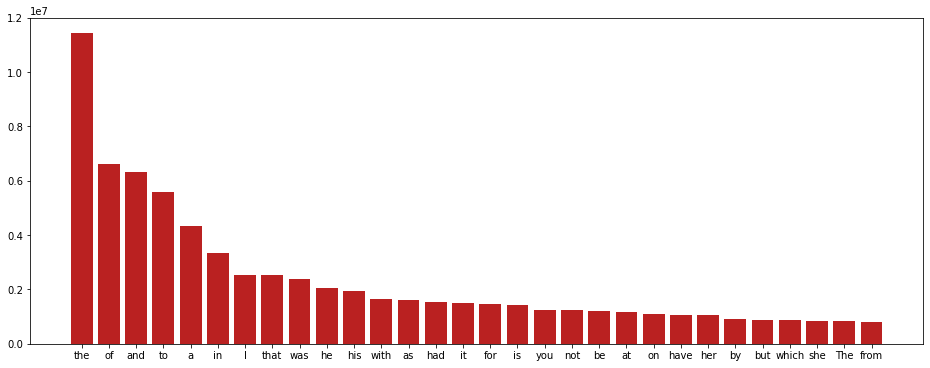

In [5]:
import matplotlib.pyplot as plt
import operator
print ('Plotting...')
freq = {}

# Read input and sort by frequency. Keep only top 30.
# Change resuts.txt with the /path/to/part-A-XXXX file 
with open('results/part-r-00000', 'rb') as csvfile:
    for line in csvfile.readlines():
        word, count = line.decode('UTF-8').split('\t')
        freq[word] = int(count)
srt = sorted(freq.items(), key=operator.itemgetter(1), reverse=True)[:30]

# Generate plot
plt.figure(figsize=(16,6))
plt.bar(range(len(srt)), [x[1] for x in srt], align='center', color='#ba2121')
plt.xticks(range(len(srt)), [x[0] for x in srt])
plt.show()

In everything is correct, the 3 most frequent words should be **`the`**, **`of`** and **`and`**.

## 3. Performance comparison
- Test your MapReduce with the smaller `gutenberg_x0.1.txt` as well. If you want, you can also try with `gutenberg_x10.txt`. For each test, **write down the running time**:

```bash
time yarn jar MapReduceWordCount.jar MapReduceWordCount /gutenberg_x0.1.txt /tmp/gut01/

real	0m48.976s
user	0m4.388s
sys	0m0.223s

time yarn jar MapReduceWordCount.jar MapReduceWordCount /gutenberg.txt /tmp/gut1/

real	3m19.905s
user	0m4.566s
sys	0m0.328s

time yarn jar MapReduceWordCount.jar MapReduceWordCount /gutenberg_x10.txt /tmp/gut10/

real	32m56.021s
user	0m7.891s
sys	0m1.100s

```

- Download the dataset on your laptop. **Note: the bigger file is optional. You need at least 12.5GB of free space in your hard drive, and will take some time to download and process!**
Alternatively, you can also run this experiment on the NameNode of your cluster, where you should still have the text files.


- We prepared a simple [wordcount program](https://bigdata2020exassets.blob.core.windows.net/ex07/python_wordcount.zip) in Python. Download it on your laptop (or the cluster NameNode) and test how long it takes to process the three datasets. **Annotate the times for the next exercise.**
    
```bash
python wordcount.py < /gutenberg_x0.1.txt

Total number of words: 21079029
Total time: 4.566 seconds

python wordcount.py < /gutenberg.txt

Total number of words: 210907704
Total time: 44.089 seconds

python wordcount.py < /gutenberg_x10.txt

Total number of words: 2109077040
Total time: 415.310 seconds

```
    
### 3.1 Plot
Compare the performance of the MapReduce vs the single-thread implementation of the word count algorithm for the three different input sizes. Fill the time in seconds in the code below to plot the results.

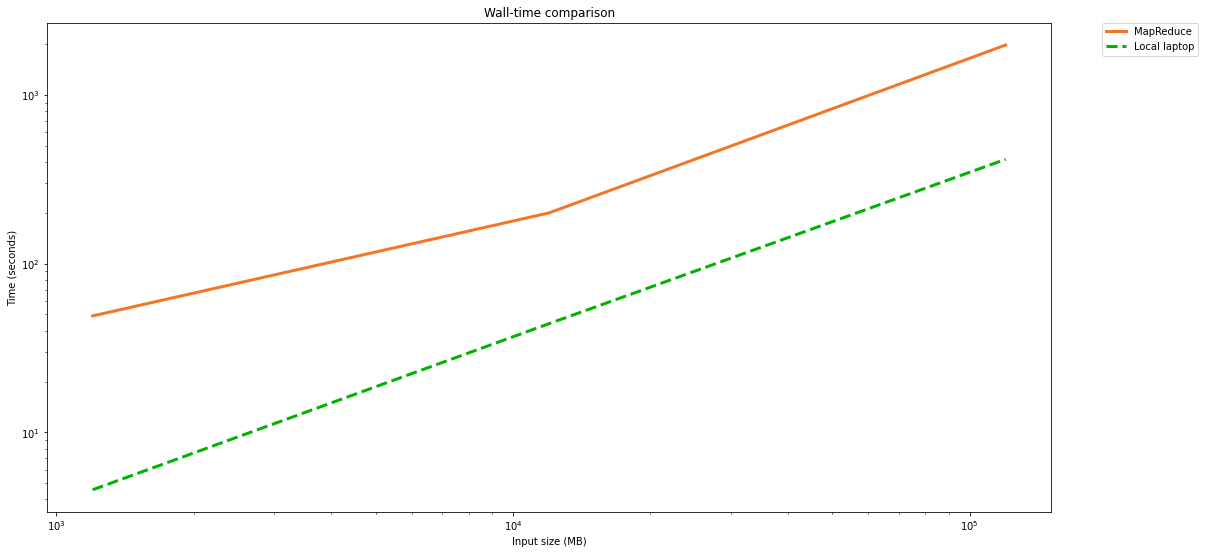

In [6]:
# NOTE: remove the last number on the lists below if you did not test gutenberg_x10.txt
size_input = [1.2*10e2, 1.2*10e3, 1.2*10e4] # the input size in MB
time_mapreduce = [48.976, 199.905, 1976.021] # replace 0s with the time (in seconds) for the corresponding inputs
time_locallaptop = [4.566, 44.089, 415.310] # replace 0s with the time (in seconds) for the corresponding inputs


%matplotlib inline
# Import plot library
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(18,9))
plt.plot(size_input, time_mapreduce, '#f37626', label='MapReduce', linewidth=3.0)
plt.plot(size_input, time_locallaptop, '#00b300', label='Local laptop', linewidth=3.0, linestyle='dashed')

plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Input size (MB)')
plt.ylabel('Time (seconds)')
plt.title('Wall-time comparison')
plt.show()

### 3.2. Discussion

We have run some more tests. Here we present the running time for 3 configurations on HDInsight, one workstation and one laptop. The figures below are indicative only, because the performance of every machine depends on several factors.

- **MapReduce v1**: no combiner with default configuration (1 reducer)
- **MapReduce v2**: no combiner with 8 reduce tasks
- **MapReduce v3**: using combiner with default configuration (1 reducer)
- **MapReduce v4**: using combiner with 8 reduce tasks
- **Workstation**: using a local workstation (server)
- **Laptop**: using a local laptop

See our performance plot below:

<img src="https://bigdata2020exassets.blob.core.windows.net/ex07/performance.png" style="width:1000px;">

1. Which line corresponds to which setting?
> (same as the order given)
1. Which is faster, MapReduce on your cluster or a local wordcount implementation? Why?
> it depends
2. Based on your experiment, what input size is the approximate break-even point for time performance?
> 1-10GB
3. Why MapReduce is not performing better than local computation for small inputs?
> The init overhead: I/O thruput limitation of shuffling
4. How can you optimize the MapReduce performance for this job?
> Combine!

## 4. Querying JSON: The Language Confusion Dataset (optional)

In this task, we will develop a MapReduce application that processes a dataset from the [language game](https://lars.yencken.org/datasets/languagegame/).
It contains rows of the following format:

```json
{"target": "Turkish",
 "sample": "af0e25c7637fb0dcdc56fac6d49aa55e",
 "choices": ["Hindi", "Lao", "Maltese", "Turkish"],
 "guess": "Maltese",
 "date": "2013-08-19",
 "country": "AU"}
```

Here, the `guess` field is what the user chose and the `target` field was the expected answer.

### 4.1. Set up

- Attach to the NameNode container:  `docker exec -it namenode /bin/bash`
- Download the data **on your local machine, not in the container**: `curl -O http://data.greatlanguagegame.com.s3.amazonaws.com/confusion-2014-03-02.tbz2`
- Extract the data: `tar -jxvf confusion-2014-03-02.tbz2`
- Copy the data to the NameNode container: `docker cp confusion-2014-03-02 namenode:/confusion-2014-03-02`
- Upload the data to HDFS: `hdfs dfs -put confusion-2014-03-02/confusion-2014-03-02.json /tmp`

### 4.2. Query implementation

- You can start with the code provided in Task 3. <br> Download the initial code `curl -O https://exerciseassets.blob.core.windows.net/exercise06/mapreduce.zip` and modify it accordingly.
- On the NameNode container, remove the old mapreduce directory: `rm -rf /mapreduce_path`
- The query to be implemented is:

**Find the number of games where the guessed language is correct (i.e., guess equal to the target one) and that language is Russian.**

- To parse a line of text, first add the next to the other imports:
```java
import com.google.gson.JsonObject;
import com.google.gson.JsonParser;
```

- Then, you can use the following to parse and access json elements:

```java
...
    JsonObject jsonObject = new JsonParser().parse(value.toString()).getAsJsonObject();
    jsonObject.get("target").getAsString();
...
```

To compile and run the code, follow the same steps as above for Exercise 2.2.
**Note: Make sure that the path to the json is the one on HDFS, not the one in the local container.**

## 5. Reverse engineering
Conceptually, a map function takes an input a key-value pair and emits a list of key-values pairs, while a reduce function takes in input a key with an associated list of values and returns a list of values or key-value pairs. Often the type of the final key and value is the same of the type of the intermediate data:

- map     `(k1,v1) --> list(k2,v2)`
- reduce  `(k2,list(v2))--> list(k2, v2)`


Analyze the following Mapper and Reducer, written in pseudo-code, and answer the questions below.

```js
function map(key, value)
  emit(key, value);

function reduce(key, values[])
  z = 0.0
  for value in values:
    z += value
  emit(key, z / values.length())
```

### Questions

#### 1. Explain what is the result of running this job on a list of pairs with type ([string], [float]).

> The average of the floats under same string.

#### 2. Write the equivalent SQL query.

```sql
SELECT AVG(values_name) FROM table_name
```

#### 3. Could you use this reduce function as combiner as well? Why or why not?

> No. cuz taking average is not associative

#### 4. If your answer to the previous question was *yes*, does the number of different keys influences the effectiveness of the combiner? If you answer was *no*, can you change the map and reduce functions in such a way the new reducer the can be used as combiner?

```js
function map(key, value)
  emit(key,(value,1));

function reduce(key, values[])
  sum = 0.0
  count = 0
  for value in values:
    sum += value[0]
    count += value[1]
  
  emit(key, sum/count)
```

## 6. True or False
Say if the following statements are *true* or *false*, and explain why.

1. Each mapper must generate the same number of key/value pairs as its input had.
> F
2. The TaskTracker is responsible for scheduling mappers and reducers and make sure all nodes are correctly running.
> F (JobTracker)
3. The input key/value pairs of mappers are sorted by the key.
> F
4. MapReduce splits might not correspond to HDFS block.
> T
5. One single Reducer is applied to all values associated with the same key.
> T
6. Multiple Reducers can be assigned **pairs with the same value.**
> T (you cannot sep by value, only by key)
7. In Hadoop MapReduce, the key-value pairs a Reducer outputs must be of the same type as its input pairs.
> F

## 7. Some more MapReduce and SQL

Design, in Python or pseudo-code, MapReduce functions that take a very large file of integers and produce as output:

### 1. The largest integer.
#### sql
```sql
SELECT MAX(values) FROM table_name;
```
#### mapreduce
```js
function map(key, value):
    emit(1, value)

function reduce(key, values[]):
    max_value = max(values)
    emit(1, max_value)
```
### 2. The average of all the integers.
#### sql
```sql
SELECT AVG(values) FROM table_name;
```

#### mapreduce
```js
function map(key, value):
    emit(1, value)

function reduce(key, values[]):
    avg_value = average(values)
    emit(1, avg_value)
```


### 3. The same set of integers, but with each integer appearing only once.
#### sql
```sql
SELECT DISTINCT values FROM table_name;
```

#### mapreduce
```js
function map(key, value):
    emit(value, value)

function reduce(key, values[]):
    first_value = values[0]
    emit(key, first_value)
```

### 4. The number of times each unique integer appears.
#### sql
```sql
SELECT COUNT(*) FROM table_name GROUP BY values; --???
```

#### mapreduce
```js
function map(key, value):
    emit(value, value)

function reduce(key, values[]):
    emit(key, values.length)
```

### 5. The number of distinct integers in the input.
#### sql
```sql
SELECT COUNT(DISTINCT values) FROM values;
```

#### mapreduce
```js
function map(key, value):
    emit(1, value)

function reduce(key, values[]):
    num_unique = set(values).length
    emit(1, num_unique)
```

For each of these, write the equivalent SQL query, assuming you have a column `values` that stores all the integers.

## 8. TF-IDF in MapReduce (optional)
Imagine we want to build a search engine over the Gutenberg dataset of ~3000 books. Given a word or a set of words, we want to rank these books according their relevance for these words. We need a metric to measure the importance of a word in a set of document...

### 8.1 Understand TF-IDF

[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a statistic to determine the relative importance of the words in a set of documents. It is computed as the product of two statistics, term frequency (`tf`) and inverse document frequency (`idf`). 

Given a word `t`, a document `d` (in this case a book) and the collection of all documents `D` we can define `tf(t, d)` as the number of times `t` appears in `d`. This gives us some information about the content of a document but because some terms (eg. "the") are so common, term frequency will tend to incorrectly emphasize documents which happen to use the word "the" more frequently, without giving enough weight to the more meaningful terms.

The inverse document frequency `idf(t, D)` is a measure of how much information the word provides, that is, whether the term is common or rare across all documents. It can be computed as:

![idf](https://bigdata2020exassets.blob.core.windows.net/ex07/idf.png)

where $|D|$ is the total number of documents and the denominator represents how many documents contain the word $t$ at least once. However, this would cause a division-by-zero exception if the user query a word that never appear in the dataset. A better formulation would be:

![idf](https://bigdata2020exassets.blob.core.windows.net/ex07/idf_smooth.png)

Then, the `tdidf(t, d, D)` is calculated as follows:

![idf](https://bigdata2020exassets.blob.core.windows.net/ex07/tfidf.png)

A high weight in `tfidf` is reached by a high term frequency (in the given document) and a low document frequency of the term in the whole collection of documents.

### 8.2 Implement TF-IDF in MapReduce (pseudo-code)
Implement Mapper and Reducer functions in pseudo-code to compute TF-IDF. Assume each Mapper receives the document name as string key and the entire document content as string value. The output of your job should be a list of key-value pairs, where the key is a string in the form "document:word" and the value is the `tfidf` score for that document/word pair.

```js
function map(doc_id, doc_content)
  ...
```

```js
function reduce(key, values[])
  ...
```